In [19]:
import numpy as np
from collections import OrderedDict
from scipy.spatial.distance import cosine
foo = OrderedDict()

for i in range(10):
    foo[i] = np.ones(5) * i


foo2 = np.stack([val for val in foo.values()])
foo1 = np.ones(5) * 2

foo1 @ (foo2.T) / (np.linalg.norm(foo1) * np.linalg.norm(foo2, axis=1) + 1e-9)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [70]:
np.stack([np.array([1, 2, 3])])

array([[1, 2, 3]])

In [34]:
[[[0.08823529 0.03921569 0.         0.00980392]
  [0.03214286 0.         0.00357143 0.02857143]
  [0.08823529 0.         0.07843137 0.05882353]
  [0.01428571 0.01071429 0.         0.01428571]
  [0.02142857 0.02857143 0.00357143 0.02857143]
  [0.03921569 0.00980392 0.02941176 0.05882353]
  [0.01785714 0.01071429 0.03214286 0.02142857]
  [0.03214286 0.00357143 0.03214286 0.01428571]
  [0.00714286 0.02142857 0.025      0.02857143]
  [0.02857143 0.03214286 0.00714286 0.        ]]]

[[3 7 0 2 4 4 9 2 8 1]
 [2 8 8 3 4 9 9 9 3 5]
 [7 6 7 8 1 8 7 0 6 2]
 [3 7 8 2 1 3 3 4 4 6]
 [2 9 8 0 4 2 5 0 9 3]
 [5 8 9 2 9 0 4 6 6 3]
 [7 8 9 4 0 8 8 1 0 0]
 [8 1 2 2 1 6 2 6 3 0]
 [7 1 4 6 0 8 2 9 9 1]
 [7 2 3 6 8 9 2 7 3 4]]
{1, 5, 6}
[[2 8 8 3 4 9 9 9 3 5]
 [5 8 9 2 9 0 4 6 6 3]
 [7 8 9 4 0 8 8 1 0 0]]


# Import packages and model

In [100]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
from hipposlam.vision import WebotImageConvertor, ImageEmbedder

In [121]:
# weights = models.quantization.MobileNet_V3_Large_QuantizedWeights.IMAGENET1K_QNNPACK_V1
# model = models.quantization.mobilenet_v3_large(weights=weights, quantize=True)

# weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
# model = models.mobilenet_v3_small(weights=weights)

weights = models.segmentation.LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.lraspp_mobilenet_v3_large()

model.eval()
preprocess = weights.transforms()
model

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\yyhho/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:03<00:00, 5.74MB/s]


LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1

# Read bytes

<class 'torch.dtype'>
torch.Size([3, 256, 256])


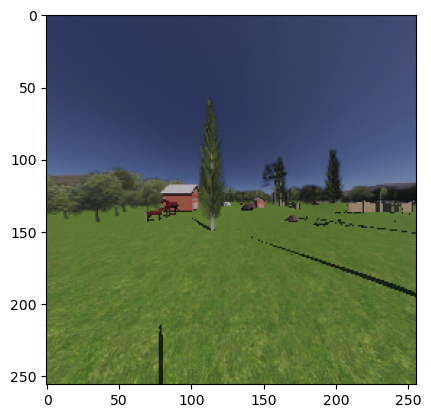

In [122]:
with open('byteImg', mode='rb') as f:
    image_bytes = bytearray(f.read())

img = torch.tensor(image_bytes).reshape((256, 256, 4))/255
# img = torch.tensor(image_bytes).reshape((256, 256, 4)).to(torch.uint8)
img = torch.flip(img, dims=[2])
img = img[:, :, 1:]
plt.imshow(img)
img = torch.permute(img, [2, 0, 1])
print(type(img.dtype))
print(img.shape)

In [116]:
batch = preprocess(img).unsqueeze(0)
prediction = model(batch).squeeze(0).softmax(0)
top5inds = torch.argsort(prediction, descending=True)[:5].numpy()
for class_id in top5inds:

    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")

print(prediction.shape)

worm fence: 28.3%
maypole: 13.0%
stupa: 7.5%
obelisk: 5.1%
pole: 4.1%
torch.Size([1000])


In [120]:

batch_t = preprocess(img).unsqueeze(0)

# Get the features from the model
with torch.no_grad():
    x = model.features(batch_t)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)

    embedding = torch.flatten(x)

embedding
print(embedding.shape)

torch.Size([576])


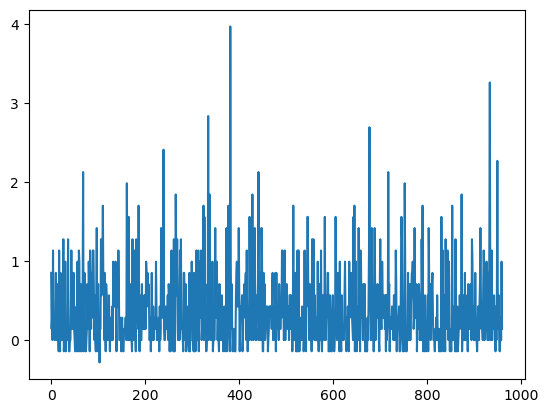

In [114]:

_ = plt.plot(embedding.squeeze())